### NOTE: Abandoned idea left as-is for the sake of documentation

In the very early stages of development the up-to-date Sentinel-5P observations were considered as a potential method to improve the timeliness of the Quality of Life indicator. This code went through some build-and-break process that we have not documented, and eventually was left in this state. Enjoy.

You can still download .tiff images with this code, and the AirX app still contains the functionality to draw the observed values over the Leaflet map.

In [3]:
from pathlib import Path
import getpass

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio import features

# what the [CENSORED] is all this [CENSORED]
from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubStatisticalDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SentinelHubStatistical,
    Geometry,
    parse_time,
)

#### NOTE: FAMILIARIZE YOURSELF WITH THE LIBRARY DOCUMENTATION FOR ALL THE ABOVE

### Load user configuration

In [4]:
config = SHConfig("cdse")

#### check what datasets are available from Sentinel-5P

In [11]:
for band in DataCollection.SENTINEL5P.bands:
    print(band.name)

CO
HCHO
NO2
O3
SO2
CH4
AER_AI_340_380
AER_AI_354_388
CLOUD_BASE_PRESSURE
CLOUD_TOP_PRESSURE
CLOUD_BASE_HEIGHT
CLOUD_TOP_HEIGHT
CLOUD_OPTICAL_THICKNESS
CLOUD_FRACTION


In [64]:
DataCollection.SENTINEL5P

<DataCollection.SENTINEL5P: DataCollectionDefinition(
  api_id: sentinel-5p-l2
  catalog_id: sentinel-5p-l2
  wfs_id: DSS7
  service_url: https://creodias.sentinel-hub.com
  collection_type: Sentinel-5P
  sensor_type: TROPOMI
  processing_level: L2
  bands: (Band(name='CO', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='HCHO', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='NO2', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='O3', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='SO2', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='CH4', units=(<Unit.PPB: 'PPB'>,), output_types=(<class 'numpy.float32'>,)), Band(name='AER_AI_340_380', units=(<Unit.INDEX: 'INDEX'>,), output_types=(<class 'numpy.float32'>,)), Band(name='AER_AI_354_388', units=(<Unit.INDEX: 'INDEX'>,), output_types=(<class 'numpy.float32'>,)), Band(name='CLOUD_BASE_PRES

### Define evalscript

In [15]:
evalscript_aer = """
//VERSION=3
function setup() {
   return {
    input: ["AER_AI_340_380"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.AER_AI_340_380] 
}
"""

### Download data using evalscript

#### NOTE: The default working directory is one where users do not have rights to save data.

Solution: save in '/home/jovyan/mystorage/testdir/data'

In [82]:
# bbox fi + swe
# 'FI': ('Finland', (20.6455928891, 59.846373196, 31.5160921567, 70.1641930203)),
# 'SE': ('Sweden', (11.0273686052, 55.3617373725, 23.9033785336, 69.1062472602)),
bbox_swefin = BBox([11.020, 55.30, 32.00, 70.17], crs=CRS.WGS84).transform(CRS(3857))

bbox_europe = BBox([-12.30, 34.59, 36.52, 67.15], crs=CRS.WGS84).transform(CRS(3857))


# This is defining the data we will use.
# You can list all available data collections with `DataCollection.get_available_collections()`.
data_5p = DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)

# config.download_timeout_seconds = 2000

request_aer = SentinelHubRequest(
    evalscript=evalscript_aer,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2024-07-01", "2024-08-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_swefin,
    # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
    # Since we have defined our bounding box in Web mercator the resolution is in meters.
    resolution=(5500, 3500),
    config=config,
    data_folder="./data",  # We save the data in a specified folder
)

In [83]:
%cd /home/jovyan/mystorage/testdir

/home/jovyan/mystorage/testdir


In [84]:
aer_data = request_aer.get_data(save_data=True)

### Plotting test

In [85]:
countries = (
    gpd.read_file("/home/jovyan/samples/sentinelhub/data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
    .to_crs(3857)
    .cx[bbox_swefin.min_x : bbox_swefin.max_x, bbox_swefin.min_y : bbox_swefin.max_y]
    .reset_index(drop=True)
)
countries = countries[["ADMIN", "geometry"]]


def plot_request(request, bbox):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        rasterio.plot.show(raster, ax=ax)
        countries.plot(ax=ax, facecolor="none", edgecolor="black")

In [ ]:
plot_request(request_aer, bbox_swefin)

#### Drawing a mean

Mean air quality. Usable only depending on time when swath was taken.

Development idea: daily time series mean function which allows evaluation of air quality independent of time.

In [59]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["AER_AI_340_380", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].AER_AI_340_380;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [60]:
request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2024-06-01", "2024-07-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_europe,
    resolution=(5000, 3500),
    config=config,
    data_folder="./data",
)

In [61]:
mean_data = request_monthly.get_data(save_data=True)

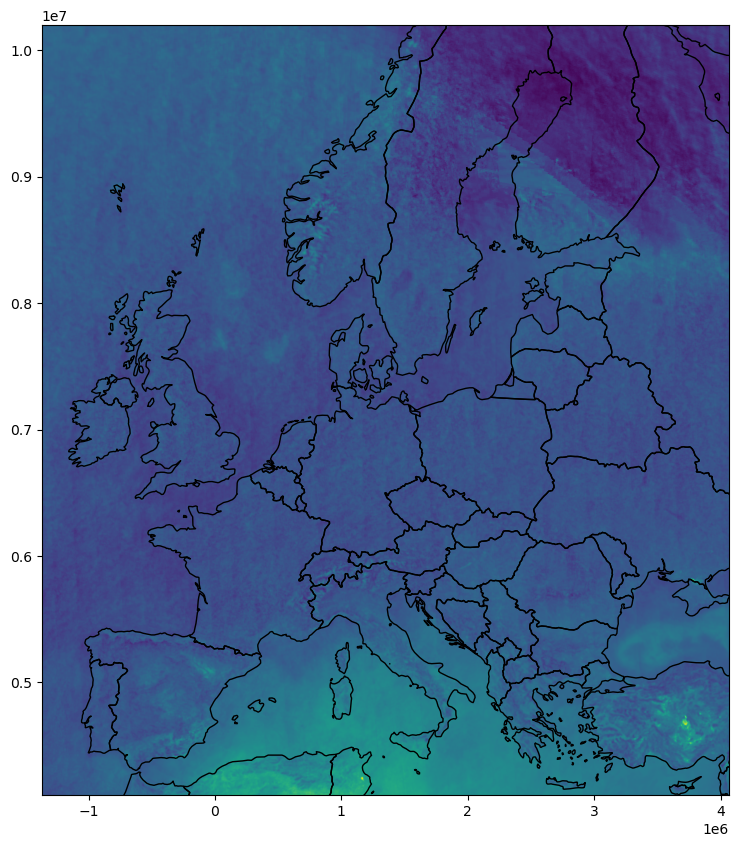

In [62]:
plot_request(request_monthly, bbox_europe) # average air quality